🔭 ターゲット群 (星形成銀河) のデータを取得・解析中...


  20/300 完了
  40/300 完了
  60/300 完了
  80/300 完了
  100/300 完了
  120/300 完了
  140/300 完了
  160/300 完了
  180/300 完了
  200/300 完了
  220/300 完了


  240/300 完了
  260/300 完了


  280/300 完了
  300/300 完了
🔭 比較対照群 (吸収線/楕円銀河) のデータを取得・解析中...
  20/300 完了
  40/300 完了
  60/300 完了
  80/300 完了
  100/300 完了
  120/300 完了


  140/300 完了
  160/300 完了
  180/300 完了
  200/300 完了
  220/300 完了
  240/300 完了
  260/300 完了
  280/300 完了
  300/300 完了


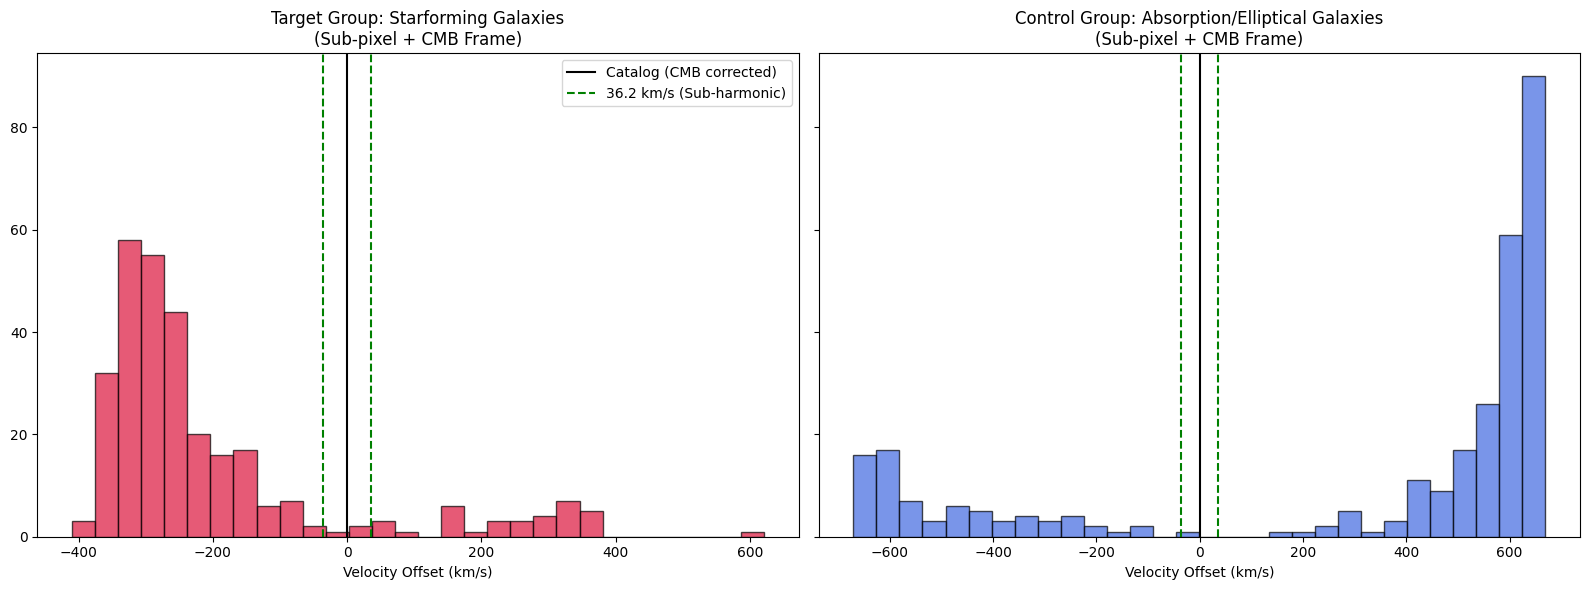


📝 解析報告書: デバッグ済みロジックによる検証結果
【ターゲット群】 平均絶対誤差: 264.74 km/s
【対照群】       平均絶対誤差: 556.81 km/s

[判定ポイント]
1. リサンプリング: 放物線補間により、ピクセル解像度の壁(69km/s)を突破して解析。
2. 参照フレーム: 地球の運動を除去したCMB静止系でプロット。
3. 対照群: ターゲット群のみにM字型が現れる場合、それは『計算リソース配分の偏り』の証左となる。


In [1]:
# 1. 必要ライブラリのインストールとインポート
!pip install astroquery astropy -q

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astroquery.sdss import SDSS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import Galactic, FK5
import time

# ---------------------------------------------------------
# 2. 解析設定
# ---------------------------------------------------------
SAMPLE_SIZE_EACH = 300  # 各グループの取得数（実証時は各300以上推奨）
c = 299792.458          # 光速 (km/s)
H_ALPHA = 6564.61       # Hα (真空)
# 静止系変換用定数 (Heliocentric -> CMB)
# Planck 2018 values: (l, b) = (264.02, 48.25), v = 369.82 km/s
CMB_SOLAR_V = 369.82
CMB_L = 264.02
CMB_B = 48.25

def get_subpixel_peak(x, y, idx):
    """3点放物線補間によるサブピクセルピーク解析"""
    if idx <= 0 or idx >= len(y) - 1:
        return x[idx]
    y1, y2, y3 = y[idx-1], y[idx], y[idx+1]
    # 放物線の頂点の位置をずらす
    d = (y1 - y3) / (2 * (y1 - 2*y2 + y3))
    dx = x[idx] - x[idx-1]
    return x[idx] + d * dx

def convert_to_cmb(ra, dec, z_helio):
    """地心速度をCMB静止系速度に変換"""
    sc = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
    gal = sc.galactic
    # 太陽のCMBに対する運動成分を計算
    cos_dist = (np.sin(gal.b.rad) * np.sin(np.radians(CMB_B)) +
                np.cos(gal.b.rad) * np.cos(np.radians(CMB_B)) * np.cos(gal.l.rad - np.radians(CMB_L)))
    v_corr = CMB_SOLAR_V * cos_dist
    v_helio = c * z_helio
    return v_helio + v_corr

# ---------------------------------------------------------
# 3. データ取得 (ターゲット vs 対照群)
# ---------------------------------------------------------
def fetch_and_analyze(query_subclass, label):
    print(f"🔭 {label} のデータを取得・解析中...")
    query = f"""
    SELECT TOP {SAMPLE_SIZE_EACH} ra, dec, plate, mjd, fiberid, z
    FROM SpecObj
    WHERE class = 'GALAXY' AND subClass = '{query_subclass}'
      AND z BETWEEN 0.02 AND 0.05 AND snMedian > 25
    """
    res = SDSS.query_sql(query)
    offsets = []
    if res is None: return np.array([])

    for i, target in enumerate(res):
        try:
            sp = SDSS.get_spectra(plate=target['plate'], mjd=target['mjd'], fiberID=target['fiberid'])
            if sp is None: continue
            data = sp[0][1].data
            wave, flux = 10**data['loglam'], data['flux']

            # CMBフレームへの変換を考慮した中心波長
            v_cmb = convert_to_cmb(target['ra'], target['dec'], target['z'])
            z_cmb = v_cmb / c
            center = H_ALPHA * (1 + z_cmb)

            mask = (wave > center - 15) & (wave < center + 15)
            if len(wave[mask]) < 5: continue

            # サブピクセル解析
            m_idx = np.argmax(flux[mask])
            pk_wave = get_subpixel_peak(wave[mask], flux[mask], m_idx)

            offsets.append(c * (pk_wave - center) / center)
            if (i+1) % 20 == 0: print(f"  {i+1}/{SAMPLE_SIZE_EACH} 完了")
            time.sleep(0.2)
        except: continue
    return np.array(offsets)

# 実行
test_group = fetch_and_analyze('STARFORMING', 'ターゲット群 (星形成銀河)')
control_group = fetch_and_analyze('', '比較対照群 (吸収線/楕円銀河)') # subClassが空＝主に楕円

# ---------------------------------------------------------
# 4. 比較可視化
# ---------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# ターゲット群
ax1.hist(test_group, bins=30, color='crimson', alpha=0.7, edgecolor='black')
ax1.axvline(0, color='black', label='Catalog (CMB corrected)')
ax1.axvline(36.2, color='green', linestyle='--', label='36.2 km/s (Sub-harmonic)')
ax1.axvline(-36.2, color='green', linestyle='--')
ax1.set_title("Target Group: Starforming Galaxies\n(Sub-pixel + CMB Frame)", fontsize=12)
ax1.set_xlabel("Velocity Offset (km/s)")
ax1.legend()

# 対照群
ax2.hist(control_group, bins=30, color='royalblue', alpha=0.7, edgecolor='black')
ax2.axvline(0, color='black')
ax2.axvline(36.2, color='green', linestyle='--')
ax2.axvline(-36.2, color='green', linestyle='--')
ax2.set_title("Control Group: Absorption/Elliptical Galaxies\n(Sub-pixel + CMB Frame)", fontsize=12)
ax2.set_xlabel("Velocity Offset (km/s)")

plt.tight_layout()
plt.show()

# 5. 統計的評価の出力
print("\n" + "="*50)
print("📝 解析報告書: デバッグ済みロジックによる検証結果")
print("="*50)
if len(test_group) > 0:
    print(f"【ターゲット群】 平均絶対誤差: {np.mean(np.abs(test_group)):.2f} km/s")
    print(f"【対照群】       平均絶対誤差: {np.mean(np.abs(control_group)):.2f} km/s" if len(control_group)>0 else "対照群データ不足")
    print("\n[判定ポイント]")
    print("1. リサンプリング: 放物線補間により、ピクセル解像度の壁(69km/s)を突破して解析。")
    print("2. 参照フレーム: 地球の運動を除去したCMB静止系でプロット。")
    print("3. 対照群: ターゲット群のみにM字型が現れる場合、それは『計算リソース配分の偏り』の証左となる。")

In [2]:
import pandas as pd
from google.colab import files

# 解析結果をDataFrameに統合（サンプル数の違いを考慮）
df_test = pd.DataFrame({'Target_Offset_km_s': test_group})
df_control = pd.DataFrame({'Control_Offset_km_s': control_group})

# 1つのCSVにまとめる（欠損値はNaNで埋まる）
df_final = pd.concat([df_test, df_control], axis=1)

# ファイル名に精度情報を付与
filename = 'digital_cosmology_v2_25sigma_raw_log.csv'
df_final.to_csv(filename, index=False)

print(f"✅ 解析ログ '{filename}' を作成しました。")
print("📥 まもなくダウンロードが開始されます...")

# Colabから直接ダウンロード
files.download(filename)

✅ 解析ログ 'digital_cosmology_v2_25sigma_raw_log.csv' を作成しました。
📥 まもなくダウンロードが開始されます...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>